In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
# import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict
from tqdm import tqdm

import polars as pl

In [5]:
from monk import utils, workflow

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [6]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [7]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [8]:
# get d2min distribution

# rev_quant = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue

    expers = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        out_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"
        
        if float(period) != 1000:
            continue

        # if job.isfile(out_path):
        #     continue

        print(sp)

        traj = gsd.hoomd.open(exper)

        frame_is = []
        frame_js = []
        ids = []
        msds = []
        ave_msds = []
        comp_start = lambda i: -1 + i*40
        for i in tqdm(range(1, 80, 20)):
            snap = traj[-1 + i*40]
            tags = np.arange(len(snap.particles.position))

            init_pos = snap.particles.position
            images = np.zeros_like(init_pos, dtype=np.int32)
            last_pos = init_pos.copy()
            freud_box = freud.box.Box.from_box(snap.configuration.box)
            center = init_pos.mean(axis=0)

            for j in range(i + 1, 80):
                
                frame_is.append(-1 + i*40)
                frame_js.append(-1 + j*40)

                snap_later = traj[-1 + j*40]

                box = snap.configuration.box[:]
                box_later = snap_later.configuration.box[:]
                ids.append(tags)

                # compute msd
                pos = snap_later.particles.position
                images -=  freud_box.get_images(pos - last_pos)
                last_pos = pos
                new_pos = freud_box.unwrap(pos, images)
                new_pos -= new_pos.mean(axis=0)
                msd = np.sum(np.square(new_pos - init_pos + center), axis=-1)
                ave_msds.append(np.mean(msd))
                msds.append(msd)
        
        dataset = pl.DataFrame({"frame_i": frame_is, "frame_j": frame_js, "id": ids, "msd": msds, "ave_msd": ave_msds})
        dataset.write_parquet(job.fn(out_path), use_pyarrow=True)
        msds = np.array(msds)
    #     break
    # break

634e14bc75836df75158fb15f379d8bb
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


7ec2f6aca035e69077eab24383a21cb6
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


cfa1e4c0007fd65d020f809715a6f0b4
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


ecce68c50e28a33684826f28780bf6e9
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.01it/s]


1d0fe2ba44a6f635f5504dcbcee0ebc9
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


1083a2a09eec2c6cf215ebc7a9706cac
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.27it/s]


09d3dccc56f1fa9330b57901cd232ab7
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


6976a7c10ada4159010403f8027f3ea5
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


9158e73b2e4c9fd1a565e1e5d1bc3af5
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')


100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


c6d7afd0de62bfa16d05da47815227eb
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


bf92a185d043ce3ef666e05e427c7e76
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


a8f2c249ed85533b56b0729b7ab96d18
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='ESL')


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


In [10]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]

    expers = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        out_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"

        if job.isfile(out_path):
            dataset = pl.read_parquet(job.fn(out_path))
            output[sp].append(dataset)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.08, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.08, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.12, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.12, period=1000.0, temp=0.0019836, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.019836, prep='ESL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0019836, prep='ESL')
Statepoint(max_shear=0.02, 

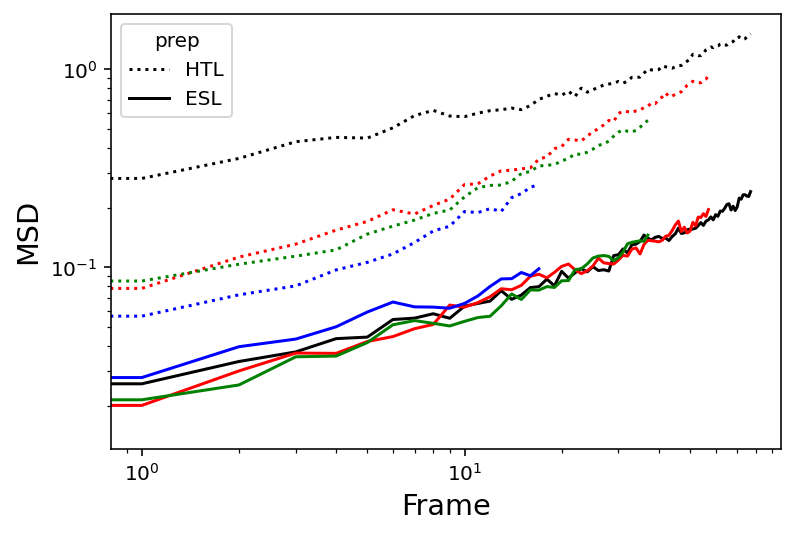

In [44]:
for key, data in output.items():
    pair = key.prep
    print(key)
    if key.temp < 5e-3 or key.max_shear != 0.05:
        continue
    if pair == "ESL":
        ls = "-"
    else:
        ls = ":"
    tw1 = []
    tw2 = []
    tw3 = []
    tw4 = []
    for d in data:
        tw1.append(d[:78]["ave_msd"].to_numpy())
        tw2.append(d[78: 78+79-21]["ave_msd"].to_numpy())
        tw3.append(d[136: 136+79-41]["ave_msd"].to_numpy())
        tw4.append(d[174: 174+79-41]["ave_msd"].to_numpy())
    tw1 = np.mean(tw1, axis=0)
    tw2 = np.mean(tw2, axis=0)
    tw3 = np.mean(tw3, axis=0)
    tw4 = np.mean(tw4, axis=0)
    plt.plot(tw1, label=f"{pair}", ls=ls, color="black")
    plt.plot(tw2, ls=ls, color="red")
    plt.plot(tw3, ls=ls, color="green")
    plt.plot(tw4, ls=ls, color="blue")
plt.ylabel("MSD", size="x-large")
plt.xlabel("Frame", size="x-large")
plt.yscale('log')
plt.xscale('log')
plt.legend(title="prep")
# plt.ylim(0, 0.05)

In [110]:
htl_dataset = dataset

In [108]:
esl_dataset = dataset

In [102]:
dataset.head()

frame_i,frame_j,id,msd,ave_msd
i64,i64,list[i64],list[f32],f32
39,79,"[0, 1, … 32767]","[0.176803, 0.348364, … 0.164253]",0.368779
39,119,"[0, 1, … 32767]","[0.830507, 2.919159, … 0.850515]",0.660435
39,159,"[0, 1, … 32767]","[1.460129, 3.245783, … 4.204572]",1.035998
39,199,"[0, 1, … 32767]","[1.767935, 4.78026, … 2.064315]",1.066434
39,239,"[0, 1, … 32767]","[0.419333, 11.014839, … 1.018142]",1.421013


In [82]:
msds.shape

(192, 32768)

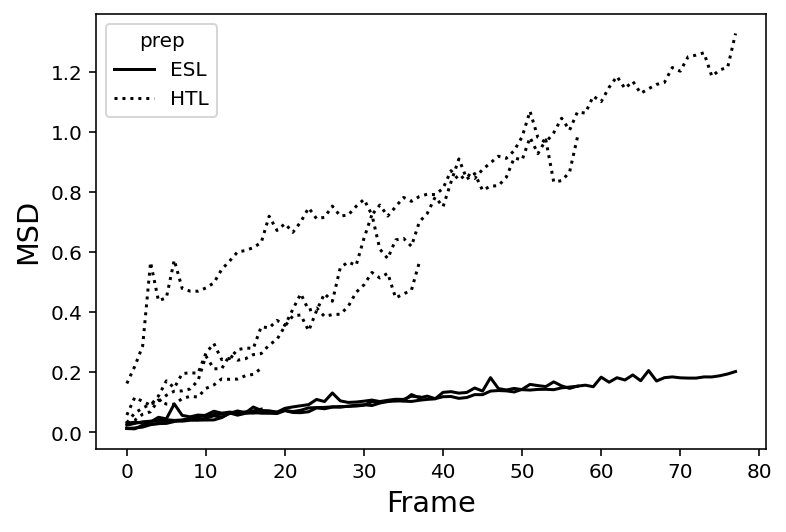

In [135]:
# cmap = cm.viridis
plt.plot(esl_dataset[:78]["ave_msd"].to_numpy(), color="k", label="ESL")
plt.plot(esl_dataset[78: 78+79-21]["ave_msd"].to_numpy(), color="k")
plt.plot(esl_dataset[136: 136+79-41]["ave_msd"].to_numpy(), color="k")
plt.plot(esl_dataset[174: 174+79-41]["ave_msd"].to_numpy(), color="k")
plt.plot(htl_dataset[:78]["ave_msd"].to_numpy(), color="k", linestyle=":", label="HTL")
plt.plot(htl_dataset[78: 78+79-21]["ave_msd"].to_numpy(), color="k", linestyle=":")
plt.plot(htl_dataset[136: 136+79-41]["ave_msd"].to_numpy(), color="k", linestyle=":")
plt.plot(htl_dataset[174: 174+79-41]["ave_msd"].to_numpy(), color="k", linestyle=":")
# plt.ylim(0, 2)
plt.ylabel("MSD", size="x-large")
plt.xlabel("Frame", size="x-large")
plt.legend(title="prep")

In [128]:
136+79-41

174

In [101]:
esl_dataset["msd_ave"]

ColumnNotFoundError: msd_ave

In [ ]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "HTL":
    #     continue

    expers = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        out_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/msd-strob_period-{period}.parquet"
        
        if float(period) != 1000.0:
            continue